# Image Captioning
This notebook will use data Kaggle(Flickr 8k Dataset) : https://www.kaggle.com/adityajn105/flickr8k

In [1]:
#Import all the required libraries

import numpy as np
import pandas as pd
import os
from skimage.io import imread
from skimage.transform import resize
import datetime
import os
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")
import glob
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
import time
from tqdm import tqdm
import shutil
import os

Using TensorFlow backend.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
base_path = "./Flickr8K/"

In [3]:
#Import the dataset and read the image into a seperate variable

images= base_path + "Images"

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [4]:
# read the captions
caption_path = base_path + "captions.txt"
captions = pd.read_csv(caption_path, sep=',')
captions = captions.set_index('image')
captions

,caption
image,
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...


A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


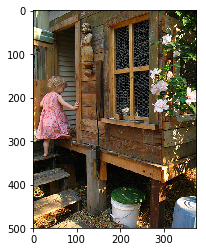

In [5]:
#Visualise both the images & text present in the dataset

# read 1st image and its captions
[print(c) for c in captions.loc[captions.index[0]].loc[:,'caption'].array]
plt.imshow(imread(images+'/'+captions.index[0]))

In [6]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    with open(caption_path) as f:
        text = [line.strip() for line in f]
    
    return text

doc = load_doc(caption_path)[1:]
print(doc[:300])

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', '

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
all_image_captions = captions.loc[:, 'caption'].array
all_img_id= captions.index.array #store all the image id here
all_img_vector= [images + '/' + path for path in all_img_id] #store all the image path here
annotations=  all_image_captions #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [8]:
#Create the vocabulary & the counter for the captions
vocabulary= [word.lower() for line in df.loc[:,'Captions'] for word in line.split(' ') if word !=''] #write your code here

val_count=Counter(vocabulary)
val_count

Counter({'a': 62986,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6713,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         '.': 36577,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18418,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
         'at': 

[('a', 62986), ('.', 36577), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765), ('man', 7265), ('of', 6713), ('two', 5638), ('white', 3940), ('black', 3832), ('boy', 3581), ('are', 3504), ('woman', 3402), ('girl', 3328), (',', 3232), ('to', 3173), ('wearing', 3062), ('at', 2914), ('people', 2883), ('water', 2783), ('red', 2672), ('young', 2630), ('brown', 2563), ('an', 2432), ('his', 2357), ('blue', 2268)]


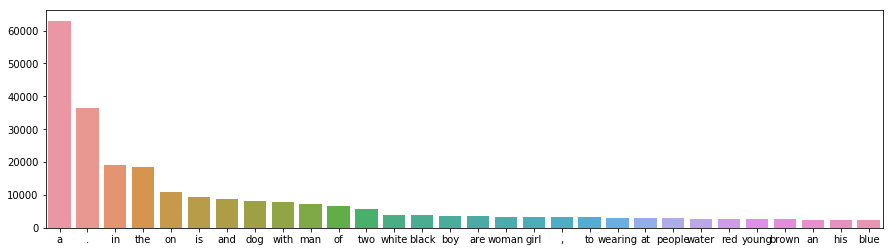

In [9]:
#Visualise the top 30 occuring words in the captions


#write your code here
print(val_count.most_common(30))

plt.figure(figsize=(15,4))
sns.barplot(x = [k for k,v in val_count.most_common(30)], y = [v for k,v in val_count.most_common(30)])

In [10]:
START_TAG = '<start>'
END_TAG = '<end>'

In [11]:
#Create a list which contains all the captions

#add the <start> & <end> token to all those captions as well

annotations= [START_TAG + ' ' + line + ' '+ END_TAG for line in df.loc[:,'Captions']] #write your code here

#Create a list which contains all the path to the images
all_img_path= [path for path in df.loc[:,'Path']] #write your code here

print("Total captions present in the dataset: ", len(annotations))
print("Total images present in the dataset: ", len(all_img_path))

Total captions present in the dataset:  40455
Total images present in the dataset:  40455


In [12]:
# add start end tag to the dataframe too
df.loc[:,'Captions'] = annotations
df.head(4)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> A child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> A girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> A little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> A little girl climbing the stairs to h...


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [13]:
# create the tokenizer

#your code here
word_tokenizer =Tokenizer(                                 # instantiate tokeniser
    num_words = 5000,                                      # top 5000 words will be considered for vocabulary
    filters='!"#$%&()*+/:=?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
    char_level=False,
    oov_token="UNK",
    document_count=0
)                      
word_tokenizer.fit_on_texts(annotations)                    # fit tokeniser on data

In [14]:
# Create word-to-index and index-to-word mappings.

#your code here
word_to_index = word_tokenizer.word_index
print('size of word_to_index', len(word_to_index))


index_to_word = word_tokenizer.index_word
print('size of index_to_word', len(index_to_word))

size of word_to_index 8914
size of index_to_word 8914


In [15]:
# print word_to_index
word_to_index

{'UNK': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 '.': 5,
 'in': 6,
 'the': 7,
 'on': 8,
 'is': 9,
 'and': 10,
 'dog': 11,
 'with': 12,
 'man': 13,
 'of': 14,
 'two': 15,
 'white': 16,
 'black': 17,
 'boy': 18,
 'are': 19,
 'woman': 20,
 'girl': 21,
 ',': 22,
 'to': 23,
 'wearing': 24,
 'at': 25,
 'people': 26,
 'water': 27,
 'red': 28,
 'young': 29,
 'brown': 30,
 'an': 31,
 'his': 32,
 'blue': 33,
 'dogs': 34,
 'running': 35,
 'through': 36,
 'playing': 37,
 'while': 38,
 'down': 39,
 'shirt': 40,
 'standing': 41,
 'ball': 42,
 'little': 43,
 'grass': 44,
 'child': 45,
 'person': 46,
 'snow': 47,
 'jumping': 48,
 'over': 49,
 'front': 50,
 'three': 51,
 'sitting': 52,
 'holding': 53,
 'field': 54,
 'small': 55,
 'up': 56,
 'by': 57,
 'large': 58,
 'green': 59,
 'group': 60,
 'one': 61,
 'yellow': 62,
 'her': 63,
 'walking': 64,
 'children': 65,
 'men': 66,
 'into': 67,
 'air': 68,
 'beach': 69,
 'near': 70,
 'mouth': 71,
 'jumps': 72,
 'another': 73,
 'for': 74,
 'street': 75,
 'runs'

In [16]:
#test the tokenizer
word_tokenizer.index_word[5000]

'fashionably'

In [17]:
# test the tokenizer
encoded_text = word_tokenizer.texts_to_sequences(["A child in a fashionably dress"])  # use the tokeniser to encode input sequence
print(encoded_text)
print(word_tokenizer.sequences_to_texts(encoded_text))

[[2, 45, 6, 2, 1, 173]]
['a child in a UNK dress']


It shows UNK for the 5000th word in the vocabulary

In [18]:
# Create a word count of your tokenizer to visualize the Top 30 occuring words after text processing

#your code here
sorted_words = sorted(word_tokenizer.word_counts.items(), key= lambda kv:kv[1], reverse=True )

for i in range(30):
    print(sorted_words[i])

('a', 62986)
('<start>', 40455)
('<end>', 40455)
('.', 36577)
('in', 18974)
('the', 18418)
('on', 10743)
('is', 9345)
('and', 8851)
('dog', 8136)
('with', 7765)
('man', 7265)
('of', 6713)
('two', 5638)
('white', 3940)
('black', 3832)
('boy', 3581)
('are', 3504)
('woman', 3402)
('girl', 3328)
(',', 3232)
('to', 3173)
('wearing', 3062)
('at', 2915)
('people', 2883)
('water', 2783)
('red', 2672)
('young', 2630)
('brown', 2563)
('an', 2432)


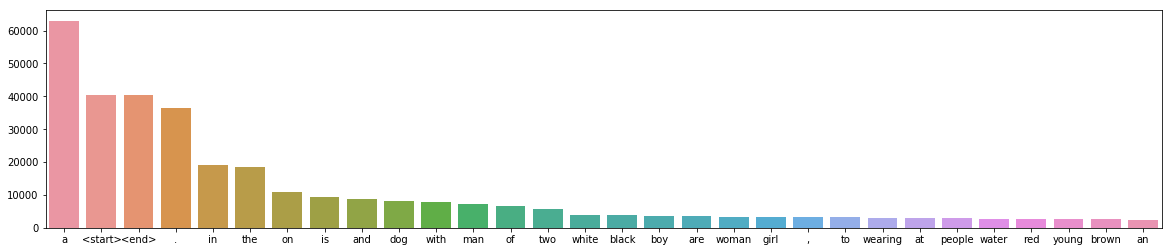

In [19]:
plt.figure(figsize=(20,4))
sns.barplot(x = [k for k,v in sorted_words[:30]], y = [v for k,v in sorted_words[:30]])

In [20]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

PADDING = "<padding>"
word_tokenizer.word_index[PADDING]  = 0
word_tokenizer.index_word[0] = PADDING
index_to_word[0] = PADDING
word_to_index[PADDING] = 0

encoded_captions =  word_tokenizer.texts_to_sequences(annotations) #your code here
cap_vector = keras.preprocessing.sequence.pad_sequences(encoded_captions, padding='post') # we are using post padding here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 40)


In [21]:
MAX_CAPTION_LENGTH = max([len(s) for s in encoded_captions])
MAX_CAPTION_LENGTH

40

In [22]:
# cross check the maximum length of all captions
max([len(s.split(" ")) for s in annotations])

40

So maximum lenght of 40 matching with the shape of the caption vector : including Start and End tag

In [23]:
# print few encoded captions and check the padding
cap_vector[:3]

array([[   3,    2,   45,    6,    2,   93,  173,    9,  122,   56,    2,
         398,   14,  395,    6,   31,    1,  696,    5,    4,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   3,    2,   21,  317,   67,    2,  197,  120,    5,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   3,    2,   43,   21,  122,   67,    2,  197, 2435,    5,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [24]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #input will be InceptionV3's input
hidden_layer = image_model.layers[-1].output #discard the last classification layer

image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

87916544/87910968 [==============================] - 1s 0us/step


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [25]:
# following method read image from disk, preprocess and return preprocessed image via inception v3 model to extract the features

shape=(299,299)
def preprocess_image(image_path, caption=""):
    # read and shape the image to target size (299,299)
    image = keras.preprocessing.image.load_img(
        image_path, grayscale=False, color_mode='rgb', target_size=shape,
        interpolation='nearest'
    )
    image = np.array(image)
    # normalize
    image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))
    # preprocess via inception v3 model to extract the features
    image = keras.applications.inception_v3.preprocess_input(image)
    return (image, caption, image_path)

In [26]:
# test the above func
temp = preprocess_image(all_img_vector[0])
print('shape', temp[0].shape, temp[1], '\n')

shape (299, 299, 3)  



## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [27]:
# combine the encoded image and caption, then shuffle
img_train, img_test, cap_train, cap_test = train_test_split(all_img_vector, cap_vector, shuffle= True, test_size=0.2, random_state=42)

print('length: train=', len(img_train), 'test=',len(img_test))

length: train= 32364 test= 8091


In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
train_dataset = train_dataset.map(lambda x,y: tf.numpy_function(func=preprocess_image, inp=[x,y], Tout=[tf.double, tf.int32, tf.string]))
train_dataset = train_dataset.batch(BATCH_SIZE,drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))
test_dataset = test_dataset.map(lambda x,y: tf.numpy_function(func=preprocess_image, inp=[x,y], Tout=[tf.double, tf.int32, tf.string]))
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=False).prefetch(buffer_size=AUTOTUNE)

In [29]:
sample_img_batch, sample_cap_batch, sample_img_paths = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64, 40)


In [30]:
sample_img_batch, sample_cap_batch, sample_img_paths = next(iter(test_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64, 40)


### Create and save features of the images to reduce computaion

As each image will produce same feature set each time we extract via InceptionV3 model, we will extract all image feature at once and save them into .npy file. While training the model we will feed this data to Attention model directly.

Create a dataset (image_dataset) which will contain all unique images

In [31]:
# create dataset with all images to save
all_unique_images = [p for p in set(all_img_vector)]
image_dataset = tf.data.Dataset.from_tensor_slices(all_unique_images)
image_dataset = image_dataset.map(lambda x: tf.numpy_function(func=preprocess_image, inp=[x], Tout=[tf.double, tf.string, tf.string]), num_parallel_calls = AUTOTUNE)
image_dataset = image_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [32]:
# test image_dataset
sample_img_batch, sample_cap_batch, paths = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)

(64, 299, 299, 3)


Define path to save prepocessed images

In [33]:
SAVED_IMAGE_PATH = base_path + "cache/Image/"
SAVED_IMAGE_PATH

'./Flickr8K/cache/Image/'

In [34]:
# remove previously processed images

def delete_previous_processed_images():
    if os.path.exists(SAVED_IMAGE_PATH):
        shutil.rmtree(SAVED_IMAGE_PATH)
        print('deleted old images from: ', SAVED_IMAGE_PATH)

In [35]:
def extract_features_from_images_and_save():
    # create the dir if not exsists
    if not os.path.exists(SAVED_IMAGE_PATH):
        os.makedirs(SAVED_IMAGE_PATH)

    all_saved_imgs = []

    # loop through all images to extract features then save the features of each image to .npy file
    for img, cap, path in tqdm(image_dataset):

        # extract the features 
        # img shape = (batch_size, 299, 299, 3)
        batch_features = image_features_extract_model(img)

        # image shape after extracting features = (batch_size, 8, 8, 2048)
        # reshape (batch_size, 8, 8, 2048) to (batch_size, 8*8, 2048)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

        # save each extracted image features to a .npy file
        for bf, p in zip(batch_features, path):
            file_name = p.numpy().decode("utf-8").split('/')[-1]
            all_saved_imgs.append(file_name)
            if not os.path.exists(SAVED_IMAGE_PATH +file_name):
                np.save( SAVED_IMAGE_PATH +file_name, bf.numpy())
                
    print('Processed image count:', len(all_saved_imgs))

In [36]:
# comment out following 2 lines after executing once, as we dont have to create preprocessed images again and again

delete_previous_processed_images()

extract_features_from_images_and_save()

0it [00:00, ?it/s]

deleted old images from:  ./Flickr8K/cache/Image/


127it [02:10,  1.03s/it]

Processed image count: 8091


##### Create func to load preprocessed images

In [37]:
# read the extracted features
def load_preprocessed_image(imgName, caption):
    file = SAVED_IMAGE_PATH + imgName.decode('utf-8').split('/')[-1] + ".npy"
    img = np.load(file)
    return img, caption

##### Create new train-test dataset which will work with the pre processed images

- train and test dataset which will load preprocessed images

In [38]:
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
train_dataset = train_dataset.map(lambda x,y: tf.numpy_function(func=load_preprocessed_image, inp=[x,y], Tout=[tf.float32, tf.int32]))
train_dataset = train_dataset.batch(BATCH_SIZE,drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))
test_dataset = test_dataset.map(lambda x,y: tf.numpy_function(func=load_preprocessed_image, inp=[x,y], Tout=[tf.float32, tf.int32]))
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=False).prefetch(buffer_size=AUTOTUNE)

In [39]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 40)


In [40]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 40)


Now we can see all pre processed images are of 8*8 size and has 2048 features each

##### Define Attention properties

In [41]:
# each image shape as evaluated by inception v3 is (64, 2048)
attention_features_count = 2048
attention_image_shape = 64

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [42]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train)/BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(img_test)/BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

As we already have pre-processed images via Inception net V3 pre trained model, we will use them as input. So our encoder will be fed with that and will have 1 Dense layer which will output 256 features

[Inception net V3 (o/p: (64, 64, 2048))] -> [Encoder (o/p: (64, 64, 256))]

In [43]:
class Encoder(keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, x):
        features = self.dense(x) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features
    
    def model(self):
        x=keras.Input(shape=(64,2048), batch_size=BATCH_SIZE)
        return keras.Model(inputs=[x],outputs=self.call(x))

In [44]:
Encoder(embedding_dim).model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 64, 2048)]          0         
_________________________________________________________________
dense (Dense)                (64, 64, 256)             524544    
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(64, 64, 256)]           0         
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


In [45]:
encoder=Encoder(embedding_dim)

### Attention model

[Encoder (o/p: (64, 64, 256))] -> [Attention model (o/p : (64, 64, 256))]  <- [Decoder (o/p : (64, 512)]

In [46]:
class Attention_model(keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1_Encoder = keras.layers.Dense(units) #build your Dense layer to process input from encoder
        self.W2_Decoder = keras.layers.Dense(units) #build your Dense layer to process input from decoder
        self.V = keras.layers.Dense(1) #build your final Dense layer with unit 1 foe scaler value
        self.units=units

    def call(self, features_vector_encoder, hidden_state_decoder):
        # features_vector_encoder shape: (batch_size, 8*8, embedding_dim) : (64, 64, 256)
        # hidden_state_decoder shape: (batch_size, hidden_size) : (64, 512)
        
        # hidden_state_decoder shape (64, 512)
        hidden_with_time_axis = tf.expand_dims(hidden_state_decoder,1)                      # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        
        # hidden_with_time_axis shape (64, 512)
        # features_vector_encoder shape (64, 64, 256)
        attention_hidden_state = tf.nn.tanh(self.W1_Encoder(features_vector_encoder) + 
                                                self.W2_Decoder(hidden_with_time_axis)) 
        
        score = self.V(attention_hidden_state)                                              # build your score funciton to shape: (batch_size, 8*8, units)
        softmax_score = tf.nn.softmax(score,axis=1)                                         # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = softmax_score * features_vector_encoder                            # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis=1)                               # reduce the shape to (batch_size, embedding_dim)
        
        # context_vector shape (64, 64, 256)
        return context_vector, softmax_score
    
    def model(self):
        x=keras.Input(shape=(64,256), batch_size=BATCH_SIZE)
        y=keras.Input(shape=(1,512), batch_size=BATCH_SIZE)
        return keras.Model(inputs=[x,y],outputs=self.call(x,y))

In [47]:
Attention_model(units).model().summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(64, 1, 512)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(64, 64, 256)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(64, 1, 1, 512)]    0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (64, 64, 512)        131584      input_3[0][0]                    
____________________________________________________________________________________________

### Decoder

last generated captions, shape = (batch_size, word_count) = (64, 1) ---------------------->

attention model output, shape = (batch_size, img_length, feature_count) = (64, 64, 256) -->   Decoder (o/p : (batch_size, vocab_size) = (64, 5001))

decoder hidden state, shape = (batch_size, decoder o/p) = (64, 512) ---------------------->

In [48]:
class Decoder(keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(units)    #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)    #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = keras.layers.Dense(units) #build your Dense layer
        self.d2 = keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,cap,features_vector_of_encoder, hidden_state_decoder):
        
        context_vector, attention_weights = self.attention(features_vector_of_encoder, hidden_state_decoder) #create your context vector & attention weights from attention model
        embed =  self.embed(cap) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector,1),embed],axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,hidden_state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,hidden_state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    
    def model(self):
        x=keras.Input(shape=(1), batch_size=BATCH_SIZE)
        y=keras.Input(shape=(64,256), batch_size=BATCH_SIZE)
        z=keras.Input(shape=(512), batch_size=BATCH_SIZE)
        return keras.Model(inputs=(x,y,z),outputs=self.call(x,y,z))

In [49]:
Decoder(embedding_dim, units, vocab_size).model().summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(64, 64, 256)]      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(64, 512)]          0                                            
__________________________________________________________________________________________________
attention_model_1 (Attention_mo ((64, 256), (64, 64, 394753      input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(64, 1)]            0                                            
____________________________________________________________________________________________

In [50]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [51]:
print('Shape of sample image batch input to encoder:', sample_img_batch.shape)
features=encoder(sample_img_batch)

print('Shape of sample caption batch input to decoder:', sample_cap_batch.shape)
hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([word_tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Shape of sample image batch input to encoder: (64, 64, 2048)
Shape of sample caption batch input to decoder: (64, 40)
Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)



## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [52]:
optimizer = keras.optimizers.Adam(learning_rate=0.001) #define the optimizer
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits= True, reduction=tf.keras.losses.Reduction.NONE) #define your loss object

In [53]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [54]:
# checkpoint to use for best result
checkpoint_path = base_path + "cache/Model_Best"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [55]:
# checkpoint to use at each epoch
checkpoint_path_last = base_path + "cache/Model_Last"
ckpt_last = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager_last = tf.train.CheckpointManager(ckpt, checkpoint_path_last, max_to_keep=1)

In [56]:
# load from checkpoints

def load_model_from_checkpoint():
    checkpoint = tf.train.Checkpoint(encoder=encoder,
                               decoder=decoder,
                               optimizer = optimizer)
    manager = tf.train.CheckpointManager(
        checkpoint, directory=checkpoint_path, max_to_keep=5)
    status = checkpoint.restore(manager.latest_checkpoint)
    print('Loading model from checkpoints : status:', status)

In [57]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden_state = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([word_tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        
        features = encoder(img_tensor, training =True)
        
        # calculate loss for batch
        for i in range(1, target.shape[1]):
            # make predictions
            decoder_output, hidden_state, _ = decoder(dec_input, features, hidden_state)
            # Calculating loss
            loss = loss + loss_function(target[:,i], decoder_output)
            # get new decoder input : use teacher forcing (use actual target instead of decoder_output for next prediction)
            dec_input = tf.expand_dims(target[:, i], 1)
        
        #calculate avg_loss by taking avg
        avg_loss = (loss/int(target.shape[1]))
        
        # get all variables to calculate gradient
        all_variables = encoder.trainable_variables + decoder.trainable_variables
        
        # calculate the gradient
        gradients = tape.gradient(loss, all_variables)
        
        #apply the gradient
        optimizer.apply_gradients(zip(gradients, all_variables))
        
    return loss, avg_loss

In [58]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden_state = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([word_tokenizer.word_index['<start>']] * target.shape[0], 1)
        
    features = encoder(img_tensor)

    # calculate loss for batch
    for i in range(1, target.shape[1]):
        # make predictions
        decoder_output, hidden_state, _ = decoder(dec_input, features, hidden_state)
        # Calculating loss
        loss = loss + loss_function(target[:,i], decoder_output)
        # get new decoder input : use decoder_output for next prediction
        predicted_pos = tf.argmax(decoder_output[0])
        dec_input = tf.expand_dims([predicted_pos] * target.shape[0], 1)

    #calculate avg_loss by taking avg
    avg_loss = (loss/int(target.shape[1]))
        
    return loss, avg_loss

In [59]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch,(img,target)) in enumerate(test_dataset):
        batch_loss, loss = test_step(img, target)
        total_loss = total_loss + loss
    
    avg_test_loss = total_loss/int(target.shape[1])
    return avg_test_loss

In [60]:
def train_model():
    loss_plot = []
    test_loss_plot = []
    EPOCHS = 15

    best_test_loss=100
    for epoch in tqdm(range(0, EPOCHS)):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(train_dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

        avg_train_loss=total_loss / train_num_steps

        loss_plot.append(avg_train_loss)    
        test_loss = test_loss_cal(test_dataset)
        test_loss_plot.append(test_loss)

        print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

        if test_loss < best_test_loss:
            print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
            best_test_loss = test_loss
            ckpt_manager.save()
            
        ckpt_manager_last.save()
        
    #plot
    plt.plot(loss_plot)
    plt.plot(test_loss_plot)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.show()

In [61]:
def create_models(load_from_checkpoints = False):
    if load_from_checkpoints:
        load_model_from_checkpoint()
    else:
        train_model()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.263, & test loss is 7.717
Time taken for 1 epoch 281.92166471481323 sec

Test loss has been reduced from 100.000 to 7.717


 13%|█▎        | 2/15 [08:01<55:47, 257.47s/it]  

For epoch: 2, the train loss is 1.047, & test loss is 8.002
Time taken for 1 epoch 198.1635284423828 sec



 20%|██        | 3/15 [11:19<47:55, 239.64s/it]

For epoch: 3, the train loss is 0.982, & test loss is 8.386
Time taken for 1 epoch 197.8911736011505 sec



 27%|██▋       | 4/15 [14:36<41:36, 226.95s/it]

For epoch: 4, the train loss is 0.938, & test loss is 8.476
Time taken for 1 epoch 197.18154859542847 sec



 33%|███▎      | 5/15 [17:54<36:21, 218.14s/it]

For epoch: 5, the train loss is 0.903, & test loss is 8.583
Time taken for 1 epoch 197.41957640647888 sec



 40%|████      | 6/15 [21:11<31:47, 211.93s/it]

For epoch: 6, the train loss is 0.873, & test loss is 8.854
Time taken for 1 epoch 197.27242827415466 sec



 47%|████▋     | 7/15 [24:29<27:40, 207.62s/it]

For epoch: 7, the train loss is 0.845, & test loss is 8.854
Time taken for 1 epoch 197.42736387252808 sec



 53%|█████▎    | 8/15 [27:46<23:51, 204.48s/it]

For epoch: 8, the train loss is 0.819, & test loss is 8.871
Time taken for 1 epoch 196.9883587360382 sec



 60%|██████    | 9/15 [31:03<20:14, 202.35s/it]

For epoch: 9, the train loss is 0.795, & test loss is 8.997
Time taken for 1 epoch 197.2325758934021 sec



 67%|██████▋   | 10/15 [34:20<16:44, 200.81s/it]

For epoch: 10, the train loss is 0.774, & test loss is 9.083
Time taken for 1 epoch 197.0610671043396 sec



 73%|███████▎  | 11/15 [37:36<13:17, 199.35s/it]

For epoch: 11, the train loss is 0.752, & test loss is 9.091
Time taken for 1 epoch 195.77996611595154 sec



 80%|████████  | 12/15 [40:53<09:55, 198.50s/it]

For epoch: 12, the train loss is 0.732, & test loss is 9.133
Time taken for 1 epoch 196.36611890792847 sec



 87%|████████▋ | 13/15 [44:09<06:35, 197.82s/it]

For epoch: 13, the train loss is 0.711, & test loss is 9.149
Time taken for 1 epoch 196.0829839706421 sec



 93%|█████████▎| 14/15 [47:27<03:17, 197.82s/it]

For epoch: 14, the train loss is 0.691, & test loss is 9.384
Time taken for 1 epoch 197.67446208000183 sec



100%|██████████| 15/15 [50:45<00:00, 197.79s/it]

For epoch: 15, the train loss is 0.670, & test loss is 9.477
Time taken for 1 epoch 197.5597686767578 sec



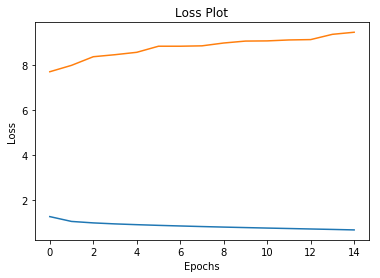

In [62]:
create_models(False)

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [89]:
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image

In [90]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [91]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [92]:
def evaluate(image):
    attention_plot = np.zeros((MAX_CAPTION_LENGTH, attention_image_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder
    

    dec_input = tf.expand_dims([word_tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(MAX_CAPTION_LENGTH):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(word_tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if word_tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [93]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
# test_image = 'Flickr8K/images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

BELU score: 1.928867353251809e-306
Real Caption: a masked person in a fight stance .
Prediction Caption: a man jumps into the air .


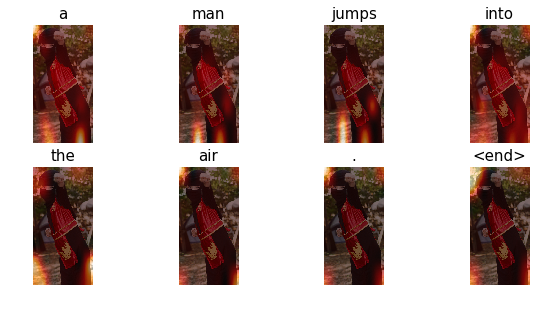

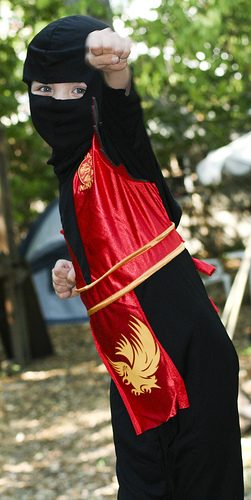

In [94]:
real_caption = ' '.join([word_tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0,0,1,0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

### Beam Search(optional)

In [95]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
    attention_plot = np.zeros((MAX_CAPTION_LENGTH, attention_image_shape))  
    
    hidden = decoder.init_state(batch_size=1)
    
    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([word_tokenizer.word_index['<start>']], 0)
    dec_input_list = [dec_input for i in range(beam_index)] # all start token
    
    start_word = [word_tokenizer.word_index["<start>"]]

    result = [[start_word, 0.0]]
    
    while len(result[0][0]) < MAX_CAPTION_LENGTH:
        i = 0 
        temp = []
        j = 0
        
        for s in result:
            dec_input = dec_input_list[j]
            j += 1
            if(j == beam_index):
                j = 0
            
            # print('dec_input:', index_to_word[int(dec_input[0][0])])
            preds, hidden, attention_weights = decoder(dec_input,features,hidden)
            attention_plot[i] = tf.reshape(attention_weights,(-1,)).numpy()
            i +=1
            # Getting the top <beam_index>(n) predictions and creating a 
            word_preds = np.argsort(preds[0])[-beam_index:]
            # print('new 3 predicted words:', [(index_to_word[i], float(preds[0][i])) for i in word_preds])
            
            for w in word_preds:
                cur_sen, cur_prob = s[0][:], s[1]
                cur_sen.append(w)
                new_prob = cur_prob + preds[0][w]
                temp.append([cur_sen, new_prob])
    
        result = temp
        
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        
        # Getting the top words
#         print('\nall sentences: --------------')
#         for sen in result:
#             print([index_to_word[i] for i in sen[0]], round(float(sen[1]),2), '\n')
        result = result[-beam_index:]
        
#         print('\nnew sentences: --------------')
#         for sen in result:
#             print([index_to_word[i] for i in sen[0]], round(float(sen[1]),2), '\n\n')
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        pred_id = pred_list[-1]       
        if(pred_id ==3):
            break            
                  
        dec_input_list = [tf.expand_dims([sen[0][-1]], 0) for sen in result]
    
    result = result[-1][0]
    intermediate_caption = [word_tokenizer.index_word[i] for i in pred_list]

    final_caption = []
    
    for i in intermediate_caption:
        if i == '<end>':
            break
        final_caption.append(i)
        
    attention_plot = attention_plot[:len(result),:]
    result = [word for word in final_caption if word != '.']
    result = ' '.join(result[1:])
    print(result)
                  
    return final_caption, result

In [96]:
beam_captions, beam_result =beam_evaluate(test_image)

an elderly woman wearing a ball


Real caption :  a masked person in a fight stance .
Predicted Beam Caption:  an elderly woman wearing a ball
BELU score: 2.2250738585072627e-306


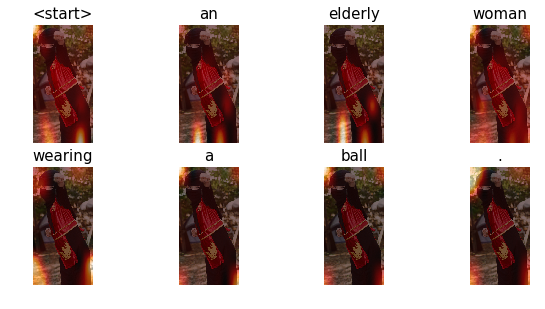

In [97]:
print('Real caption : ', filt_text(real_caption) )
print('Predicted Beam Caption: ', beam_result)

score = sentence_bleu(real_caption.split(), beam_result.split(), weights=(0,0,1,0))
print(f"BELU score: {score*100}")

plot_attmap(beam_captions, attention_plot, test_image)

## Text to speech

In [98]:
#!pip install gTTS

In [99]:
from gtts import gTTS
import IPython

text = beam_result

language = 'en'

obj = gTTS(text=text, lang=language, slow=False)

obj.save("caption.mp3")

#os.system("caption.mp3")

IPython.display.Audio("caption.mp3")

### Conclusion: 

As shown above the model generates captions. As part of hyper parameter tuning we can try changing the batch size to 32 and 128 also.

1. With 32 batch size the best model gives the loss of ~16 
2. whereas with 128 batch size the model gives loss of ~3. But it tends to overfit the data.

Best outcome is ovserved with 64 btach size and this jupyter notebook shows the data with only 64 batch size. Other 2 batch sizes has not been shown to keep the notebook clean.